# 06b: Transformer Baesd Modelling: TimesFmModelForPrediction

## Overview

This notebook builds and evaluates a deep learning model for ICU mortality prediction by combining dynamic time series data (via a pretrained TimesFM backbone) with static patient features.

**Goal**  
Accurately predict in-hospital mortality by fusing temporal physiological signals with static characteristics.

**Key Components**  
- Data loading and PyTorch Dataset creation  
- Custom model: `ICUStaticFusionTimesFM` with TimesFM backbone, static feature fusion, and classifier head  
- `ICUStaticFusionTimesFM_Trainer` class for training, evaluation, weighted sampling, and model checkpointing

**Evaluation Stages**  
- Baseline: Pretrained model without fine-tuning  
- Trained: Model trained on ICU mortality dataset  
- Tuned: Model optimized via Optuna hyperparameter tuning

**Metrics Used**  
AUROC, PR_AUC, Accuracy, Precision, Recall, F1-score — with emphasis on the minority class ("Died")

**Findings**  
- Pretrained model showed limited task-specific performance  
- Training improved metrics significantly  
- Optuna tuning boosted recall for "Died" class, critical for identifying high-risk patients  
- SHAP analysis added interpretability by highlighting key features  
- Tuned model achieved the best overall balance for this imbalanced classification task

## 1. Import Necessary Libraries

This section imports all the required Python libraries for the notebook, including those for data manipulation (pandas, numpy), visualization (matplotlib, seaborn), deep learning (torch, torch.nn, torch.optim), Hugging Face transformers, hyperparameter tuning (optuna), and model interpretability (shap).

In [ ]:
%pip install optuna shap
%pip install --upgrade transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 142.6 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.54.1
    Uninstalling transformers-4.54.1:
      Successfully uninstalled transformers-4.54.1


In [ ]:
import sys
import os
import time
import torch
import optuna
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import torch.nn as nn
import torch.optim as optim
from collections import Counter, defaultdict
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from transformers import TimesFmModelForPrediction
from huggingface_hub import login

# Supress warnings
import warnings
warnings.filterwarnings('ignore')

## 2. Mount Google Drive

This section mounts the Google Drive to access files directly within the Colab environment.

In [ ]:
from google.colab import drive

# Mount Google drive
drive.mount('/content/drive')

# Base file path
basePath = 'drive/MyDrive/Colab Notebooks/AAI-590-01_02/AAI590_CapstoneProject'

Mounted at /content/drive


## 3. HuggingFace Login

This section authenticates with the Hugging Face Hub, which is necessary to access the pretrained TimesFM model used in this notebook.

In [ ]:
# Set huggingface token as environment variable
os.environ["HF_TOKEN"] = "<huggingface_token>"

# Authenticate
login(token=os.getenv("HF_TOKEN"))

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


## 4. Load Transformer Feature Data

This section loads the pre-processed data that will be used to train and evaluate the model. It loads the static and dynamic data, along with their corresponding attention masks, into separate Pandas DataFrames and displayed.

In [ ]:
# Define the directory where feature files are saved
features_dir = os.path.join(basePath, 'data', 'features')

# Note: use below code if running in the local machine
# static_data_cleaned_file_path = r'../data/features/transformer_static_data_v2.csv'
# static_attention_mask_file_path = r'../data/features/transformer_static_attention_mask_v2.csv'
# patch_level_file_path = r'../data/features/transformer_dynamic_data_v2.csv'
# dynamic_attention_mask_file_path = r'../data/features/transformer_dynamic_attention_mask_v2.csv'

# Define file paths for each dataframe
static_data_cleaned_file_path = os.path.join(features_dir, 'transformer_static_data_v2.csv')
static_attention_mask_file_path = os.path.join(features_dir, 'transformer_static_attention_mask_v2.csv')
patch_level_file_path = os.path.join(features_dir, 'transformer_dynamic_data_v2.csv')
dynamic_attention_mask_file_path = os.path.join(features_dir, 'transformer_dynamic_attention_mask_v2.csv')

# Load the static and dynamic data into pandas DataFrames
transformer_static_data_df = pd.read_csv(static_data_cleaned_file_path)
transformer_static_attention_mask_df = pd.read_csv(static_attention_mask_file_path)
transformer_dynamic_data_df = pd.read_csv(patch_level_file_path)
transformer_dynamic_attention_mask_df = pd.read_csv(dynamic_attention_mask_file_path)

# Print the shape of each DataFrame to verify that the data has been loaded correctly
print("Static Data Shape:", transformer_static_data_df.shape)
print("Static Attention Mask Shape:", transformer_static_attention_mask_df.shape)
print("Dynamic Data Shape:", transformer_dynamic_data_df.shape)
print("Dynamic Attention Mask Shape:", transformer_dynamic_attention_mask_df.shape)

Static Data Shape: (4000, 5)
Static Attention Mask Shape: (4000, 5)
Dynamic Data Shape: (191856, 20)
Dynamic Attention Mask Shape: (191856, 20)


In [ ]:
transformer_static_data_df.head()

,RecordID,Gender,ICUType,In-hospital_death,AgeBMI_token_encoded
0,140101,0,3,0,8
1,140102,0,3,0,25
2,140104,1,2,0,12
3,140106,1,2,0,14
4,140107,1,3,0,17


In [ ]:
transformer_static_attention_mask_df.head()

,RecordID,Gender,ICUType,In-hospital_death,AgeBMI_token_encoded
0,140101,1,1,1,1
1,140102,1,1,1,0
2,140104,1,1,1,1
3,140106,1,1,1,1
4,140107,1,1,1,0


In [ ]:
transformer_dynamic_data_df.head()

,RecordID,TimeBin,HCT,MechVent,NIDiasABP,NIMAP,NISysABP,RespRate,Urine,pH,ShockIndex,PulsePressure,MeanSysRatio,PaO2_FiO2,RespQuotient,Temp_HR,GCS_MAP,HR_bin_enc,MAP_bin_enc,GCS_bin_enc
0,132539,0-60,0.415878,1.0,0.330632,1.115615,1.523818,-0.062473,1.314870,-0.01841,-0.376300,-0.033685,-0.03617,-0.215229,-0.148224,-0.253415,0.136129,1.0,2.0,0.0
1,132539,60-120,0.415878,1.0,0.366022,0.789919,0.887245,-0.405697,-0.384400,-0.01841,-0.837212,-0.033685,-0.03617,-0.215229,-0.148224,-0.728439,0.136129,0.0,2.0,0.0
2,132539,120-180,0.415878,1.0,-0.341788,-0.001107,0.293111,-0.062473,-0.128596,-0.01841,-0.775757,-0.033685,-0.03617,-0.215229,-0.148224,-0.667225,0.136129,1.0,2.0,0.0
3,132539,180-240,0.415878,1.0,-0.341788,-0.105833,0.102140,0.109139,-0.018966,-0.01841,-0.499210,-0.033685,-0.03617,-0.215229,-0.148224,-0.463014,0.136129,1.0,2.0,0.0
4,132539,240-300,0.415878,1.0,-0.341788,-0.210558,-0.088832,0.280751,-0.329585,-0.01841,-0.407027,-0.033685,-0.03617,-0.215229,-0.148224,-0.431759,0.136129,1.0,2.0,0.0


In [ ]:
transformer_dynamic_attention_mask_df.head()

,RecordID,TimeBin,HCT,MechVent,NIDiasABP,NIMAP,NISysABP,RespRate,Urine,pH,ShockIndex,PulsePressure,MeanSysRatio,PaO2_FiO2,RespQuotient,Temp_HR,GCS_MAP,HR_bin_enc,MAP_bin_enc,GCS_bin_enc
0,132539,0-60,0,0,1,1,1,1,1,0,0,0,0,0,0,1,0,1,0,1
1,132539,60-120,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,1,0,0
2,132539,120-180,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,1,0,0
3,132539,180-240,1,0,1,1,1,1,1,0,0,0,0,0,0,1,0,1,0,1
4,132539,240-300,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


## 5. Prepare Model Input

This section focuses on preparing the data for the model. It includes two main steps: building temporal tensors and splitting the data. The first step involves converting the raw data into a format that can be fed into the model, while the second step splits the data into training, validation, and test sets to ensure that the model is trained and evaluated on different data.

### 5.1 Build Temporal Tensors

This section defines a function to extract static & dynamic patient data, labels, and attention masks from the loaded DataFrames and convert them into PyTorch tensors. The function groups the data by patient, ensures each patient has the correct number of time steps, and then creates tensors for the features, labels and attention masks. Finally, it calls this function to generate the `static_tensor`, `dynamic_tensor`, `y`, `static_mask`, and `dynamic_mask` tensors for the model.

In [ ]:
# Function to extract patient data and labels from a DataFrame and converts them into PyTorch tensors
def extract_patient_Xy(static_df, dynamic_df, record_col='RecordID', time_col='TimeBin', label_col='In-hospital_death'):
    static_tensors = []
    dynamic_tensors = []
    labels = []

    # Group the dynamic data by patient
    for record_id, group in dynamic_df.groupby(record_col):
        # Sort the data by time
        group_sorted = group.sort_values(by=time_col)

        # Ensure each patient has the correct number of time steps
        if len(group_sorted) != 48:
            # This patient does not have all 48 time bins, so we skip them.
            continue

        # Get the label for the patient from the static data
        static_patient_data = static_df[static_df[record_col] == record_id]
        if static_patient_data.empty:
            raise ValueError(f"Patient {record_id} not found in static data.")

        y_val = static_patient_data[label_col].iloc[0]
        # Get the static features for the patient
        static_features = static_patient_data.drop(columns=[record_col, label_col]).values

        # Get the dynamic features for the patient
        dynamic_features = group_sorted.drop(columns=[record_col, time_col]).values

        # Convert the features and labels to PyTorch tensors
        static_tensor = torch.tensor(static_features, dtype=torch.float32)
        dynamic_tensor = torch.tensor(dynamic_features, dtype=torch.float32)

        static_tensors.append(static_tensor)
        dynamic_tensors.append(dynamic_tensor)
        labels.append(y_val)

    # Stack the tensors for all patients and return features and labels
    return torch.cat(static_tensors), torch.stack(dynamic_tensors), torch.tensor(labels, dtype=torch.long)

# Extract the features and labels from the combined DataFrame
static_tensor, dynamic_tensor, y = extract_patient_Xy(transformer_static_data_df, transformer_dynamic_data_df)

# Print the shape of the tensors
print("Static Tensor Shape:", static_tensor.shape)
print("Dynamic Tensor Shape:", dynamic_tensor.shape)
print("Labels Shape:", y.shape)

Static Tensor Shape: torch.Size([3997, 3])
Dynamic Tensor Shape: torch.Size([3997, 48, 18])
Labels Shape: torch.Size([3997])


In [ ]:
# Extract the features and labels from the combined attention mask DataFrame
staic_mask, dynamic_mask, _ = extract_patient_Xy(transformer_static_attention_mask_df, transformer_dynamic_attention_mask_df)

# Print the shape of the tensors
print("Static Mask Shape:", staic_mask.shape)
print("Dynamic Mask Shape:", dynamic_mask.shape)

Static Mask Shape: torch.Size([3997, 3])
Dynamic Mask Shape: torch.Size([3997, 48, 18])


### 5.2 Split Data

This section defines a function to split the data into training, validation, and test sets. The function takes the feature tensor, the label tensor, and the attention mask tensor as input, along with the desired ratios for the training and validation sets. It then splits the data in a stratified manner, ensuring that the class distribution is maintained across the different sets. Finally, it prints the class distribution and the shape of each set to verify that the data has been split correctly.

In [ ]:
# Function to split the data into training, validation, and test sets
def time_series_balanced_split(X_static, X_dynamic, y, X_mask_static, X_mask_dynamic, train_ratio=0.6, val_ratio=0.2):
    class_indices = defaultdict(list)
    for idx, label in enumerate(y):
        class_indices[int(label)].append(idx)

    X_static_train, X_dynamic_train, y_train, X_mask_static_train, X_mask_dynamic_train = [], [], [], [], []
    X_static_val, X_dynamic_val, y_val, X_mask_static_val, X_mask_dynamic_val = [], [], [], [], []
    X_static_test, X_dynamic_test, y_test, X_mask_static_test, X_mask_dynamic_test = [], [], [], [], []

    for label, indices in class_indices.items():
        sorted_idx = sorted(indices)
        n_total = len(sorted_idx)
        n_train = ceil(n_total * train_ratio)
        n_val   = ceil(n_total * val_ratio)

        train_idx = sorted_idx[:n_train]
        val_idx   = sorted_idx[n_train:n_train + n_val]
        test_idx  = sorted_idx[n_train + n_val:]

        for i in train_idx:
            X_static_train.append(X_static[i])
            X_dynamic_train.append(X_dynamic[i])
            y_train.append(y[i])
            if X_mask_static is not None:
                X_mask_static_train.append(X_mask_static[i])
            if X_mask_dynamic is not None:
                X_mask_dynamic_train.append(X_mask_dynamic[i])

        for i in val_idx:
            X_static_val.append(X_static[i])
            X_dynamic_val.append(X_dynamic[i])
            y_val.append(y[i])
            if X_mask_static is not None:
                X_mask_static_val.append(X_mask_static[i])
            if X_mask_dynamic is not None:
                X_mask_dynamic_val.append(X_mask_dynamic[i])

        for i in test_idx:
            X_static_test.append(X_static[i])
            X_dynamic_test.append(X_dynamic[i])
            y_test.append(y[i])
            if X_mask_static is not None:
                X_mask_static_test.append(X_mask_static[i])
            if X_mask_dynamic is not None:
                X_mask_dynamic_test.append(X_mask_dynamic[i])


    return (
        np.array(X_static_train), np.array(X_dynamic_train), np.array(y_train), np.array(X_mask_static_train) if X_mask_static is not None else None, np.array(X_mask_dynamic_train) if X_mask_dynamic is not None else None,
        np.array(X_static_val), np.array(X_dynamic_val), np.array(y_val), np.array(X_mask_static_val) if X_mask_static is not None else None, np.array(X_mask_dynamic_val) if X_mask_dynamic is not None else None,
        np.array(X_static_test), np.array(X_dynamic_test), np.array(y_test), np.array(X_mask_static_test) if X_mask_static is not None else None, np.array(X_mask_dynamic_test) if X_mask_dynamic is not None else None,
    )

# Split the data into training, validation, and test sets
X_static_train, X_dynamic_train, y_train, X_mask_static_train, X_mask_dynamic_train, X_static_val, X_dynamic_val, y_val, _, _, X_static_test, X_dynamic_test, y_test, _, _ = time_series_balanced_split(static_tensor, dynamic_tensor, y, staic_mask, dynamic_mask)

# Print the class distribution and the shape of each set
print("Train:", Counter(y_train), "| Static Shape:", X_static_train.shape, "| Dynamic Shape:", X_dynamic_train.shape, "| Static Mask Shape:", X_mask_static_train.shape, "| Dynamic Mask Shape:", X_mask_dynamic_train.shape)
print("Val:", Counter(y_val), "| Static Shape:", X_static_val.shape, "| Dynamic Shape:", X_dynamic_val.shape)
print("Test:", Counter(y_test), "| Static Shape:", X_static_test.shape, "| Dynamic Shape:", X_dynamic_test.shape)

Train: Counter({np.int64(0): 2066, np.int64(1): 333}) | Static Shape: (2399, 3) | Dynamic Shape: (2399, 48, 18) | Static Mask Shape: (2399, 3) | Dynamic Mask Shape: (2399, 48, 18)
Val: Counter({np.int64(0): 689, np.int64(1): 111}) | Static Shape: (800, 3) | Dynamic Shape: (800, 48, 18)
Test: Counter({np.int64(0): 688, np.int64(1): 110}) | Static Shape: (798, 3) | Dynamic Shape: (798, 48, 18)


## 6. Model Architecture and Utilities

This section outlines the core components for building and training the ICU mortality prediction model. It defines the `ICUStaticFusionTimesFM` model architecture, which fuses dynamic time series data processed by a pretrained TimesFM with static patient features. It also introduces the `ICUFusionDataset` for handling the combined data and the `ICUStaticFusionTimesFM_Trainer` class, which manages the training, evaluation, and plotting of the model's performance.

### 6.1 ICUStaticFusionTimesFM Model

The `ICUStaticFusionTimesFM` model is designed for ICU mortality prediction by fusing dynamic time series data with static patient information. It utilizes a pretrained TimesFM model to process the dynamic time series features, extracting temporal representations. These dynamic representations are then concatenated with projected static features. The combined features are passed through a classifier head to predict the probability of in-hospital death. This architecture leverages the power of TimesFM for time series analysis and integrates static patient context for improved prediction performance.

In [ ]:
class ICUStaticFusionTimesFM(nn.Module):
    # Initialize the model with static and dynamic feature dimensions, and other parameters
    def __init__(self, static_feature_dim, num_dynamic_features, static_projection_size=64, classifier_hidden_size=128, dropout_rate=0.2, timesfm_model="google/timesfm-2.0-500m-pytorch", forecast_context_len=128, forecast_horizon=1, num_classes=2):
        super().__init__()
        self.static_feature_dim = static_feature_dim
        self.num_dynamic_features = num_dynamic_features
        self.static_projection_size = static_projection_size
        self.classifier_hidden_size = classifier_hidden_size
        self.forecast_context_len = forecast_context_len
        self.forecast_horizon = forecast_horizon
        self.num_classes = num_classes

        # Load TimesFM model from Hugging Face
        self.timesfm = TimesFmModelForPrediction.from_pretrained(
            timesfm_model,
            torch_dtype=torch.bfloat16, # Use bfloat16 for potentially faster training and reduced memory usage
            attn_implementation="sdpa" # Use Scaled Dot Product Attention for efficiency
        )

        # Linear layer to project static features to a lower dimension
        self.static_projection = nn.Linear(static_feature_dim, self.static_projection_size)

        # Classifier head - takes concatenated TimesFM output and projected static features
        # The input dimension is the number of dynamic features * forecast_horizon (from TimesFM) + projected static feature size
        timesfm_output_dim = forecast_horizon # TimesFM outputs a single value per time series for the forecast horizon
        self.classifier = nn.Sequential(
            nn.Linear(self.num_dynamic_features * timesfm_output_dim + self.static_projection_size, self.classifier_hidden_size),
            nn.ReLU(), # ReLU activation function
            nn.Dropout(dropout_rate), # Dropout for regularization
            nn.Linear(self.classifier_hidden_size, num_classes) # Output layer with number of classes
        )


    # Forward pass of the model
    def forward(self, dynamic_inputs, static_features, frequency_inputs):
        # dynamic_inputs is expected to be a single tensor of shape [batch_size, sequence_length, num_dynamic_features]
        # static_features is a tensor of shape [batch_size, static_feature_dim]
        # frequency_inputs is a tensor of shape [batch_size]

        timesfm_outputs = []
        # Iterate through each dynamic feature for processing with TimesFM
        for i in range(self.num_dynamic_features):
             # Extract the time series for the i-th dynamic feature across the batch
             # Shape: [batch_size, sequence_length]
            dynamic_feature_ts_batch = dynamic_inputs[:, :, i]

            # Convert the batch time series for this feature into a LIST of individual time series
            # Each tensor in the list will have shape [sequence_length]
            batch_dynamic_input_list = [dynamic_feature_ts_batch[j] for j in range(dynamic_feature_ts_batch.shape[0])]

            # Ensure frequency input matches the batch size
            batch_freq_input = frequency_inputs

            # Pass the list of time series for the current feature to TimesFM
            outputs = self.timesfm(
                 past_values=batch_dynamic_input_list, # This is now a list of [sequence_length] tensors
                 freq=batch_freq_input,
                 return_dict=True, # Return outputs as a dictionary
                 forecast_context_len=self.forecast_context_len # Context length for forecasting
             )
            # We take the mean prediction for the first step in the forecast horizon
            # The shape of mean_predictions is [batch_size, forecast_horizon]
            timesfm_outputs.append(outputs.mean_predictions[:, 0])


        # Concatenate TimesFM outputs for all dynamic features along the feature dimension
        # The shape will be [batch_size, num_dynamic_features * forecast_horizon] (since forecast_horizon is 1, this is [batch_size, num_dynamic_features])
        combined_timesfm_output = torch.stack(timesfm_outputs, dim=1)


        # Project static features using the linear layer
        projected_static = self.static_projection(static_features) # Shape: [batch_size, self.static_projection_size]

        # Concatenate TimesFM output and projected static features
        combined_features = torch.cat([combined_timesfm_output, projected_static], dim=1) # Shape: [batch_size, num_dynamic_features * forecast_horizon + self.static_projection_size]

        # Pass the combined features through the classifier head
        logits = self.classifier(combined_features)
        return logits # Return the output logits

### 6.2 ICUStaticFusionTimesFM Dataset

The `ICUFusionDataset` is a custom PyTorch Dataset designed to handle the combined static and dynamic data for the `ICUStaticFusionTimesFM` model. It encapsulates the static features, dynamic time series data, and corresponding mortality labels. This class ensures that individual patient data, including their dynamic time series and static information, can be efficiently accessed and loaded in batches by a PyTorch DataLoader for model training and evaluation.

In [ ]:
class ICUFusionDataset(Dataset):
    # Initialize the dataset with static data, dynamic data, and labels
    def __init__(self, static_data, dynamic_data, labels):
        # Convert static data to a PyTorch tensor with bfloat16 dtype
        self.static_data = torch.tensor(static_data, dtype=torch.bfloat16)
        # Convert dynamic data to a PyTorch tensor with bfloat16 dtype
        self.dynamic_data = torch.tensor(dynamic_data, dtype=torch.bfloat16)
        # Create a frequency tensor, initialized to zeros, with the same length as the labels
        # The frequency is needed for the TimesFM model; it's set to zero here as the data is regularly windowed every 60 minutes.
        self.freq = torch.zeros(len(labels), dtype=torch.long)
        # Convert labels to a PyTorch tensor with long dtype
        self.labels = torch.tensor(labels, dtype=torch.long)

    # Return the total number of samples in the dataset
    def __len__(self):
        return len(self.labels)

    # Get a single sample from the dataset at the given index
    def __getitem__(self, idx):
        # Return the dynamic data, static data, frequency, and label for the given index
        # The dynamic data is returned as a list of tensors for compatibility with the TimesFM model input format.
        # For TimesFM model, freq is expected to be a list, so we return the corresponding freq
        return self.dynamic_data[idx], self.static_data[idx], self.freq[idx], self.labels[idx]

### 6.3 ICUStaticFusionTimesFM Trainer

The `ICUStaticFusionTimesFM_Trainer` class encapsulates the training and evaluation logic for the `ICUStaticFusionTimesFM` model. It handles the creation of DataLoaders, defines the loss function and optimizer, and provides methods for training the model for a specified number of epochs with early stopping, evaluating the model on validation and test sets, calculating various performance metrics, and visualizing results through plots such as confusion matrices, ROC curves, and Precision-Recall curves. It also includes functionality to save and load the trained model state.

In [ ]:
class ICUStaticFusionTimesFM_Trainer:
    def __init__(self, model, train_dataset, val_dataset, test_dataset, batch_size, sampler, learning_rate, weight_decay, device):
        self.model = model
        self.device = device

        # Create DataLoaders internally
        self.train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler) if train_dataset else None
        self.val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) if val_dataset else None
        self.test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) if test_dataset else None

        # Create criterion and optimizer internally
        self.criterion = nn.CrossEntropyLoss() # Using CrossEntropyLoss for binary classification
        self.optimizer = optim.AdamW(self.model.parameters(), lr=learning_rate, weight_decay=weight_decay)

        # Store metrics
        self.train_losses = []
        self.val_losses = []
        self.val_aurocs = []
        self.test_metrics = {}

        # Store best model state and metric during training
        self.best_val_auroc = -float('inf')
        self.best_model_state = None
        self.best_params = None

    # Trains the model for one epoch
    def train_epoch(self):
        self.model.train()
        running_loss = 0.0
        for dynamic_data, static_data, freq, labels in self.train_loader:
            dynamic_data = dynamic_data.to(self.device)
            static_data = static_data.to(self.device)
            labels = labels.to(self.device).long()

            self.optimizer.zero_grad()
            outputs = self.model(dynamic_data, static_data, freq)
            loss = self.criterion(outputs.squeeze(), labels)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
        return running_loss / len(self.train_loader)

    # Evaluates the model on the given dataloader
    def evaluate(self, dataloader):
        self.model.eval()
        all_preds = []
        all_labels = []
        running_loss = 0.0
        with torch.no_grad():
            for dynamic_data, static_data, freq, labels in dataloader:
                dynamic_data = dynamic_data.to(self.device)
                static_data = static_data.to(self.device)
                labels = labels.to(self.device)

                outputs = self.model(dynamic_data, static_data, freq)
                loss = self.criterion(outputs.squeeze(), labels)
                running_loss += loss.item()

                # For binary classification, get probability of class 1
                probs = torch.softmax(outputs.squeeze(), dim=-1)[:, 1]

                all_preds.extend(probs.cpu().float().numpy())
                all_labels.extend(labels.cpu().float().numpy())

        avg_loss = running_loss / len(dataloader)
        metrics = self.calculate_metrics(all_preds, all_labels)
        return avg_loss, metrics, all_preds, all_labels

    # Calculates various evaluation metrics
    def calculate_metrics(self, preds, labels):
        auroc = roc_auc_score(labels, preds)
        optimal_threshold = self.calculate_optimal_threshold(preds, labels)
        binary_preds = [1 if p >= optimal_threshold else 0 for p in preds]

        report = classification_report(labels, binary_preds, output_dict=True, target_names=['0', '1'], zero_division=0)

        metrics = {
            "AUROC": auroc,
            "Accuracy": report["accuracy"],
            "Precision (survived)": report.get("0", {}).get("precision", 0.0),
            "Precision (died)": report.get("1", {}).get("precision", 0.0),
            "Recall (survived)": report.get("0", {}).get("recall", 0.0),
            "Recall (died)": report.get("1", {}).get("recall", 0.0),
            "F1-score (survived)": report.get("0", {}).get("f1-score", 0.0),
            "F1-score (died)": report.get("1", {}).get("f1-score", 0.0),
        }

        precision, recall, _ = precision_recall_curve(labels, preds)
        pr_auc = auc(recall, precision)
        metrics["PR_AUC"] = pr_auc

        return metrics

    # Calculates the optimal threshold for binary classification based on ROC curve
    def calculate_optimal_threshold(self, preds, targets):
        fpr, tpr, thresholds = roc_curve(targets, preds)
        # Handle the case where there's only one class
        if len(np.unique(targets)) == 1:
             return 0.5 # Or raise an error, depending on desired behavior
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]
        return optimal_threshold

    # Trains the model for a specified number of epochs with early stopping
    def train(self, epochs, early_stopping_patience=5, plot_training_metrics=True):
        early_stopping_counter = 0

        print(f"Starting training on device: {self.device}")

        for epoch in range(epochs):
            train_loss = self.train_epoch()
            val_loss, val_metrics, _, _ = self.evaluate(self.val_loader)
            val_auroc = val_metrics["AUROC"]

            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.val_aurocs.append(val_auroc)

            print(f"Epoch {epoch + 1:02d}/{epochs}: Train Loss = {train_loss:.4f} | Val Loss = {val_loss:.4f} | Val AUROC = {val_auroc:.4f}")

            if val_auroc > self.best_val_auroc:
                self.best_val_auroc = val_auroc
                early_stopping_counter = 0
                # Store the best model state dictionary
                self.best_model_state = self.model.state_dict()
            else:
                early_stopping_counter += 1
                if early_stopping_counter >= early_stopping_patience:
                    print(f"Early stopping triggered after {early_stopping_patience} epochs without improvement.")
                    break

        print("Training finished.")
        if plot_training_metrics:
            self.plot_training_metrics()

    # Evaluates the trained model on the test set and plots results
    def evaluate_test(self):
        print("\nEvaluating model on the test set...")
        test_loss, test_metrics, test_preds, test_labels = self.evaluate(self.test_loader)
        self.test_metrics = test_metrics

        print("\nTest Set Evaluation Metrics:")
        for metric, value in self.test_metrics.items():
            print(f"{metric}: {value:.4f}")

        # Calculate optimal threshold for the test set for binary classification
        optimal_threshold = self.calculate_optimal_threshold(test_preds, test_labels)
        binary_test_preds = [1 if p >= optimal_threshold else 0 for p in test_preds]


        print("\nClassification Report:")
        print(classification_report(test_labels, binary_test_preds))

        cm = confusion_matrix(test_labels, binary_test_preds)
        self.plot_confusion_matrix(cm, title='ICUStaticFusionTimesFM: Confusion Matrix')

        fpr, tpr, _ = roc_curve(test_labels, test_preds)
        self.plot_roc_curve(fpr, tpr, self.test_metrics['AUROC'], title='ICUStaticFusionTimesFM: ROC Curve')

        precision, recall, _ = precision_recall_curve(test_labels, test_preds)
        self.plot_pr_curve(precision, recall, self.test_metrics['PR_AUC'], title='ICUStaticFusionTimesFM: PR Curve')

    # Plots the training loss and validation AUROC curves
    def plot_training_metrics(self):
        epochs = range(1, len(self.train_losses) + 1)

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.train_losses, label='Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss per Epoch')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.val_aurocs, label='Validation AUROC', color='orange')
        plt.xlabel('Epoch')
        plt.ylabel('AUROC')
        plt.title('Validation AUROC per Epoch')
        plt.legend()

        plt.tight_layout()
        plt.show()

    # Plots the confusion matrix
    def plot_confusion_matrix(self, cm, title='Confusion Matrix'):
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Survived (0)', 'Died (1)'], yticklabels=['Survived (0)', 'Died (1)'])
        plt.title(title)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

    # Plots the ROC curve
    def plot_roc_curve(self, fpr, tpr, roc_auc, title='ROC Curve'):
        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(title)
        plt.legend(loc="lower right")
        plt.show()

    # Plots the Precision-Recall curve
    def plot_pr_curve(self, precision, recall, pr_auc, title="Precision-Recall Curve"):
        plt.figure(figsize=(6, 4))
        plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(title)
        plt.legend(loc="lower left")
        plt.show()

    # Saves the model state dictionary and optional parameters
    def save_model(self, path, params=None):
        save_dict = {
            'model_state_dict': self.model.state_dict(),
        }
        if params is not None:
            save_dict['params'] = params
        torch.save(save_dict, path)
        print(f"Model state dictionary and parameters saved to {path}")

    # Loads the model state dictionary from a saved checkpoint
    def load_model(self, path):
        checkpoint = torch.load(path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Model state dictionary loaded from {path}")
        if 'params' in checkpoint:
            print("Parameters loaded from checkpoint.")
            return checkpoint['params']
        return None

## 7. Pretrained Model Evaluation: ICUStaticFusionTimesFM with Pretrained TimesFM

This section focuses on evaluating the performance of the `ICUStaticFusionTimesFM` model using a pretrained TimesFM backbone, without any further training on the ICU mortality dataset, highlighting the model's performance prior to being trained on the specific task data.

### 7.1 Evaluation

This section focuses on evaluating the performance of the `ICUStaticFusionTimesFM` model using a pretrained TimesFM backbone, **without** further training on the ICU mortality dataset. The model is instantiated and immediately evaluated on the prepared test dataset to establish a baseline performance using the out-of-the-box capabilities of the pretrained TimesFM model combined with the static fusion and classifier head.

**Interpretations:**

* **AUROC (0.6015)**: An AUROC of 0.6015 indicates that the model has some ability to distinguish between the two classes (Survived and Died), but its performance is only slightly better than random chance (an AUROC of 0.5). There is significant room for improvement.
* **Accuracy (0.6504)**: The overall accuracy of 65.04% means that the model correctly predicted the outcome for about two-thirds of the patients in the test set. However, given the class imbalance (more Survived cases than Died cases), accuracy alone can be misleading.
* **Classification Report:**
  * **Precision (Survived - 0.8925)**: When the model predicts a patient will survive, it is correct about 89.3% of the time. This is a relatively high precision for the majority class.
  * **Precision (Died - 0.1949)**: When the model predicts a patient will die, it is correct only about 19.5% of the time. This low precision for the minority class (Died) suggests a high number of false positives (predicting death when the patient survived).
  * **Recall (Survived - 0.6759)**: The model correctly identifies about 67.6% of the patients who actually survived.
  * **Recall (Died - 0.4909)**: The model correctly identifies about 49.1% of the patients who actually died. This means roughly half of the patients who died were missed by the model (false negatives).
  * **F1-score (Survived - 0.7692)**: The F1-score for the Survived class is reasonably good, representing a balance between precision and recall for this class.
  * **F1-score (Died - 0.2791)**: The F1-score for the Died class is quite low, highlighting the difficulty the model has in correctly identifying the minority class, due to both low precision and moderate recall.
* **Confusion Matrix:**
  * **True Positives (Died)**: 54 patients were correctly predicted as Died.
  * **False Positives (Died)**: 223 patients were incorrectly predicted as Died (they actually Survived). This large number of false positives is reflected in the low precision for the Died class.
  * **True Negatives (Survived)**: 465 patients were correctly predicted as Survived.
  * **False Negatives (Survived)**: 56 patients were incorrectly predicted as Survived (they actually Died). This number of false negatives is reflected in the moderate recall for the Died class.
* **ROC Curve**: The ROC curve shows the trade-off between the True Positive Rate (Recall) and the False Positive Rate at various threshold settings. The curve is closer to the diagonal line (representing random chance) than the top-left corner, which is consistent with the modest AUROC score.
* **PR Curve (0.1740)**: The Precision-Recall curve focuses on the performance on the positive class (Died). An area under the PR curve (PR_AUC) of 0.1740 is quite low, this emphasizes the model's struggle with correctly identifying the minority class with high precision.

This suggests that directly using the pretrained TimesFM for this specific downstream task without fine-tuning on the target dataset is not sufficient to achieve high predictive performance.

In [ ]:
# Create Dataset instances for training, validation, and testing
train_dataset = ICUFusionDataset(X_static_train, X_dynamic_train, y_train)
val_dataset = ICUFusionDataset(X_static_val, X_dynamic_val, y_val)
test_dataset = ICUFusionDataset(X_static_test, X_dynamic_test, y_test)

# Define parameters for the model and training
batch_size = 32
learning_rate = 1e-4
weight_decay = 1e-2

# Determine the device to use for training (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get feature dimensions from the test set
test_static_feature_dim = X_static_test.shape[-1]
test_num_dynamic_features = X_dynamic_test.shape[-1]

Evaluating pretrained ICUStaticFusionTimesFM model on the test set (without further training)...

Evaluating model on the test set...

Test Set Evaluation Metrics:
AUROC: 0.6015
Accuracy: 0.6504
Precision (survived): 0.8925
Precision (died): 0.1949
Recall (survived): 0.6759
Recall (died): 0.4909
F1-score (survived): 0.7692
F1-score (died): 0.2791
PR_AUC: 0.1740

Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.68      0.77       688
         1.0       0.19      0.49      0.28       110

    accuracy                           0.65       798
   macro avg       0.54      0.58      0.52       798
weighted avg       0.80      0.65      0.70       798



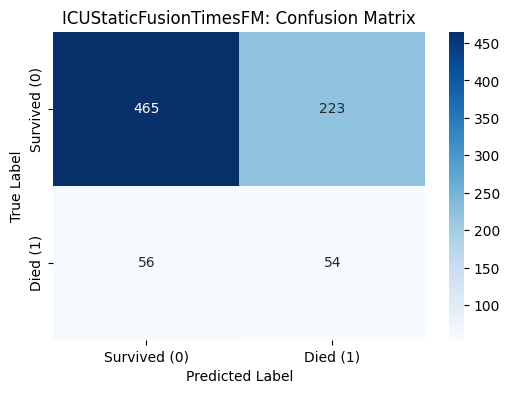

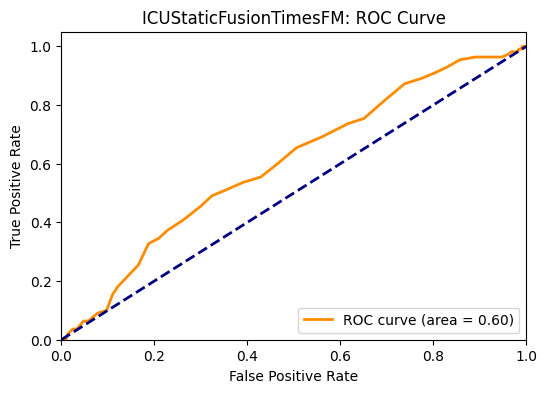

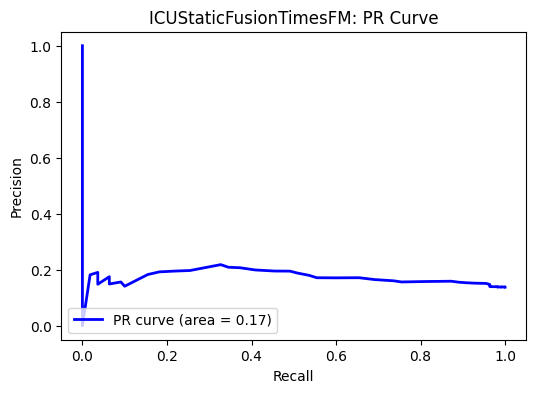

In [ ]:
# Initialize the ICUStaticFusionTimesFM model
pretrained_model = ICUStaticFusionTimesFM(static_feature_dim=test_static_feature_dim, num_dynamic_features=test_num_dynamic_features)
pretrained_model.to(device)
pretrained_model.to(torch.bfloat16)

# Initialize the ICUStaticFusionTimesFM_Trainer
eval_trainer_pretrained = ICUStaticFusionTimesFM_Trainer(
    model=pretrained_model,
    train_dataset=None, # No training needed
    val_dataset=None,   # No validation needed
    test_dataset=test_dataset,
    batch_size=batch_size,
    sampler=None, # No sampler needed
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    device=device
)

# Evaluate the pretrained TimesFM model on the test set
print("Evaluating pretrained ICUStaticFusionTimesFM model on the test set (without further training)...")
eval_trainer_pretrained.evaluate_test()

## 8. Trained Model: ICUStaticFusionTimesFM Trained on ICU Mortality Dataset

This section details the process of training the `ICUStaticFusionTimesFM` model on the ICU mortality dataset and evaluating its performance on a held-out test set.

### 8.1 Model Training

This section details the training process for the `ICUStaticFusionTimesFM` model on the ICU mortality dataset. It involves setting up the training environment, including defining hyperparameters and **utilizing a weighted sampler to address class imbalance**. The model is trained using the `ICUStaticFusionTimesFM_Trainer` class for a specified number of epochs with early stopping based on validation performance. Finally, the state dictionary of the trained model is saved for later evaluation and analysis.

In [ ]:
# Note: use below code if running in the local machine
# timesFM_path = r'../models/timesfm.pt'

# Define the path to the saved model within Google Drive
models_dir = os.path.join(basePath, 'models')
timesFM_path = os.path.join(models_dir, 'timesfm.pt')

# Define the number of training epochs and early stopping patience
epochs = 10
early_stopping_patience = 5

# Get feature dimensions for model initialization from the training data
train_static_feature_dim = X_static_train.shape[-1]
train_num_dynamic_features = X_dynamic_train.shape[-1]

# Using the weighted sampler for the training DataLoader to handle class imbalance
# Calculate class weights based on the inverse frequency of each class in the training labels
# Create a WeightedRandomSampler to sample training data based on these weights
class_weights = [1.0 / Counter(y_train)[cls] for cls in y_train]
sampler = WeightedRandomSampler(class_weights, len(y_train))

Starting training on device: cuda
Epoch 01/10: Train Loss = 0.7622 | Val Loss = 0.7605 | Val AUROC = 0.5541
Epoch 02/10: Train Loss = 0.7177 | Val Loss = 0.5834 | Val AUROC = 0.5954
Epoch 03/10: Train Loss = 0.6523 | Val Loss = 0.5787 | Val AUROC = 0.5715
Epoch 04/10: Train Loss = 0.6979 | Val Loss = 0.6767 | Val AUROC = 0.5816
Epoch 05/10: Train Loss = 0.9220 | Val Loss = 0.6925 | Val AUROC = 0.5459
Epoch 06/10: Train Loss = 0.7531 | Val Loss = 0.7192 | Val AUROC = 0.6219
Epoch 07/10: Train Loss = 0.7371 | Val Loss = 0.7300 | Val AUROC = 0.5950
Epoch 08/10: Train Loss = 0.7168 | Val Loss = 0.7386 | Val AUROC = 0.6322
Epoch 09/10: Train Loss = 0.7146 | Val Loss = 0.6564 | Val AUROC = 0.6362
Epoch 10/10: Train Loss = 0.7110 | Val Loss = 0.6669 | Val AUROC = 0.6369
Training finished.


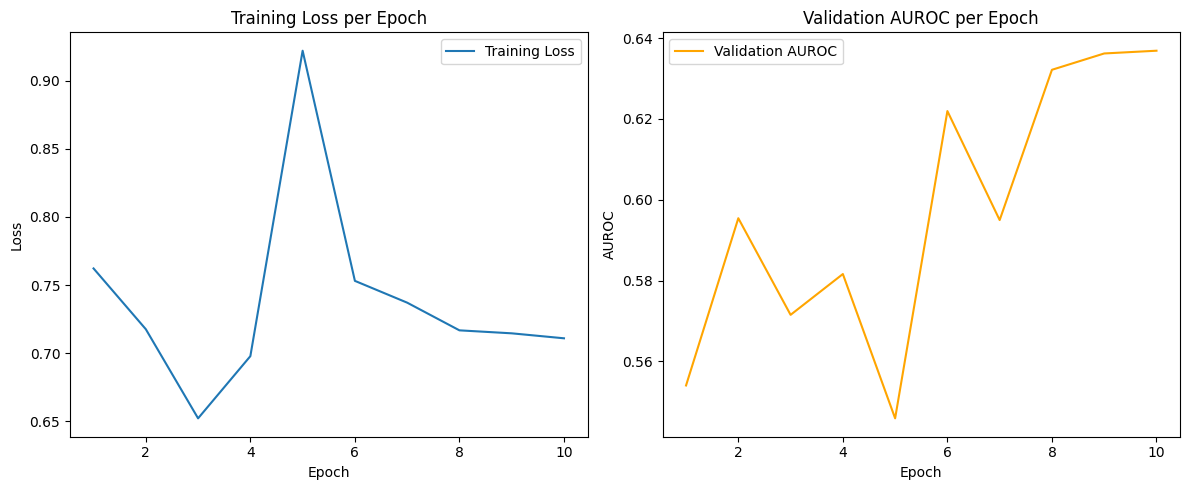

Model state dictionary and parameters saved to drive/MyDrive/Colab Notebooks/AAI-590-01_02/AAI590_CapstoneProject/models/timesfm.pt
CPU times: user 54min 42s, sys: 5min, total: 59min 43s
Wall time: 59min 33s


In [ ]:
%%time

# Initialize the ICUStaticFusionTimesFM model with training data dimensions
model = ICUStaticFusionTimesFM(static_feature_dim=train_static_feature_dim, num_dynamic_features=train_num_dynamic_features)
# Move the model to the specified device (GPU or CPU)
model.to(device)
# Convert the model parameters to bfloat16 for potential performance benefits
model.to(torch.bfloat16)

# Create an instance of the ICUStaticFusionTimesFM_Trainer
trainer = ICUStaticFusionTimesFM_Trainer(
    model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    batch_size=batch_size,
    sampler=sampler,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    device=device
)

# Train the model using the trainer instance
trainer.train(epochs=epochs, early_stopping_patience=early_stopping_patience)

# Save the trained model's state dictionary
trainer.save_model(timesFM_path)

### 8.2 Evaluation

This section presents the evaluation of the `ICUStaticFusionTimesFM` model after it has been trained on the ICU mortality dataset. Using the `ICUStaticFusionTimesFM_Trainer`, the trained model is evaluated on the held-out test set to assess its performance on unseen data. The evaluation includes calculating various metrics such as AUROC, Accuracy, Precision, Recall, and F1-score, as well as generating plots like the confusion matrix, ROC curve, and Precision-Recall curve to provide a comprehensive understanding of the model's predictive capabilities for in-hospital death.

**Interpretations:**

*   **AUROC (0.6518):** The AUROC has increased from 0.6015 to 0.6518, indicating a better ability to distinguish between patients who survive and those who die after training on the specific dataset. While still not exceptionally high, this shows the value of fine-tuning.
*   **Accuracy (0.7318):** The accuracy has also improved from 0.6504 to 0.7318. This suggests the model is making more correct overall predictions.
*   **Classification Report:**
    *   **Precision (Survived - 0.9031):** Precision for the majority class remains high and has slightly improved.
    *   **Precision (Died - 0.2524):** Precision for the minority class ("Died") has increased from 0.1949 to 0.2524. While still low, this indicates that when the model predicts death, it is correct more often than the pretrained model.
    *   **Recall (Survived - 0.7718):** Recall for the "Survived" class has improved, meaning the model is better at identifying patients who survive.
    *   **Recall (Died - 0.4818):** Recall for the "Died" class remains similar (0.4818 vs 0.4909), indicating the model's ability to find actual death cases hasn't changed significantly.
    *   **F1-score (Died - 0.3312):** The F1-score for the "Died" class has improved from 0.2791 to 0.3312, reflecting the combined effect of increased precision and stable recall.
*   **Confusion Matrix:**
    *   The number of True Positives (Died) is similar (53 vs 54), but the number of False Positives (predicting Died when Survived) has decreased significantly (157 vs 223). This reduction in False Positives contributes to the improved precision for the "Died" class.
    *   The number of True Negatives (Survived) has increased (531 vs 465), aligning with the improved accuracy and recall for the "Survived" class.
    *   The number of False Negatives (predicting Survived when Died) is similar (57 vs 56).
*   **ROC Curve:** The ROC curve is further away from the diagonal and closer to the top-left corner compared to the pretrained model's ROC curve, visually confirming the improved discrimination ability reflected by the higher AUROC.
*   **PR Curve (0.2287):** The PR_AUC has increased from 0.1740 to 0.2287. This is a positive sign for the performance on the minority class, indicating a better trade-off between precision and recall for predicting death.

After training the `ICUStaticFusionTimesFM` model on the ICU mortality dataset, there is a notable improvement in performance compared to the pretrained model evaluation (Section 7.1), particularly in reducing false positives for the "Died" class and improving overall accuracy and AUROC.

Model state dictionary loaded from drive/MyDrive/Colab Notebooks/AAI-590-01_02/AAI590_CapstoneProject/models/timesfm.pt

Evaluating model on the test set...

Test Set Evaluation Metrics:
AUROC: 0.6518
Accuracy: 0.7318
Precision (survived): 0.9031
Precision (died): 0.2524
Recall (survived): 0.7718
Recall (died): 0.4818
F1-score (survived): 0.8323
F1-score (died): 0.3312
PR_AUC: 0.2287

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.77      0.83       688
         1.0       0.25      0.48      0.33       110

    accuracy                           0.73       798
   macro avg       0.58      0.63      0.58       798
weighted avg       0.81      0.73      0.76       798



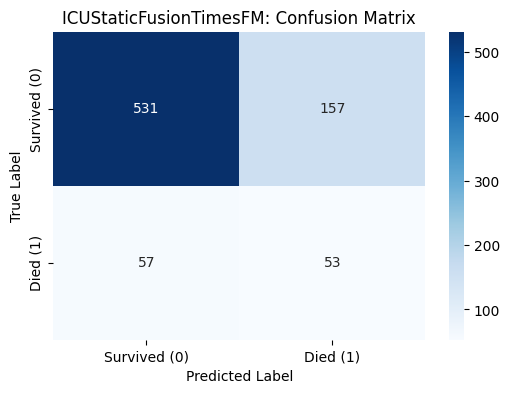

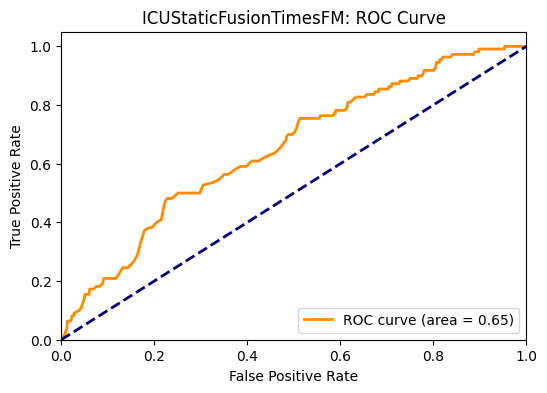

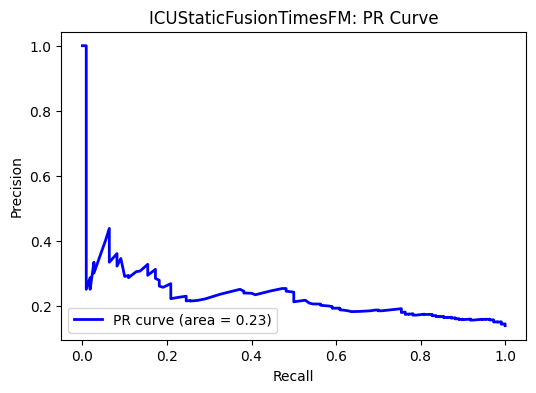

In [ ]:
# Evaluate on the test set
trainer.evaluate_test()

## 9. Hyperparameter Tuning with Optuna: Optimizing ICUStaticFusionTimesFM on ICU Mortality Dataset

This section details the process of optimizing the `ICUStaticFusionTimesFM` model's performance through hyperparameter tuning using the Optuna framework. It outlines the definition of the objective function for optimization, which involves training and evaluating the model with different hyperparameters, and the execution of the Optuna study to identify the best combination of parameters based on validation performance. The section also includes the evaluation of the model with the optimal hyperparameters and an interpretation of its predictions using SHAP to understand the impact of different features.

### 9.1 Model Training

This section focuses on setting up and executing the hyperparameter tuning process using Optuna. It defines the `objective` function that Optuna will optimize. This function trains the `ICUStaticFusionTimesFM` model with a given set of hyperparameters suggested by Optuna and returns the validation AUROC, which serves as the metric to be maximized during tuning. The section then initializes and runs the Optuna study to find the best combination of hyperparameters for the model on the ICU mortality prediction task.

In [ ]:
def objective(trial, model_save_path):
    # Define Hyperparameters to Tune
    static_projection_size = trial.suggest_categorical("static_projection_size", [32, 64, 128])
    classifier_hidden_size = trial.suggest_categorical("classifier_hidden_size", [64, 128, 256])
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    # Initialize the model with suggested hyperparameters
    model = ICUStaticFusionTimesFM(
        static_feature_dim=train_static_feature_dim,
        num_dynamic_features=train_num_dynamic_features,
        static_projection_size=static_projection_size,
        classifier_hidden_size=classifier_hidden_size,
        dropout_rate=dropout_rate
    )
    model.to(device)
    model.to(torch.bfloat16)

    # Create trainer instance for this trial with suggested hyperparameters
    trainer = ICUStaticFusionTimesFM_Trainer(
        model=model,
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        test_dataset=None,
        batch_size=batch_size,
        sampler=sampler,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        device=device
    )

    # Train the model for this trial using the trainer
    trainer.train(epochs=epochs, early_stopping_patience=early_stopping_patience, plot_training_metrics=False)

    # Get the best validation AUROC
    auroc = trainer.best_val_auroc

    # Report the best validation AUROC of this trial to Optuna
    trial.report(auroc, 0)

    # Save the model if it's the best one so far
    if auroc is not None and (trial.number == 0 or auroc > study.best_value):
        trainer.save_model(model_save_path, trial.params)

    print(f"Trial {trial.number}: AUROC = {auroc:.4f}")

    return auroc if auroc is not None else 0.0

In [ ]:
%%time

# Note: use below code if running in the local machine
# timesFM_bm_path = r'../models/timesfm_bm.pt'

# Define the path to the saved model
timesFM_bm_path = os.path.join(models_dir, 'timesfm_bm.pt')

# Create a new study
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, timesFM_bm_path), n_trials=10)

# Display best hyperparameters
print("Best hyperparameters:", study.best_params)

[I 2025-08-06 20:18:54,346] A new study created in memory with name: no-name-fdc5547d-52ad-4d86-bc8b-c9b942c0a897


config.json:   0%|          | 0.00/692 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

Starting training on device: cuda
Epoch 01/10: Train Loss = 11.7249 | Val Loss = 0.7809 | Val AUROC = 0.5157
Epoch 02/10: Train Loss = 0.8295 | Val Loss = 0.6839 | Val AUROC = 0.5627
Epoch 03/10: Train Loss = 0.8017 | Val Loss = 0.6995 | Val AUROC = 0.5900
Epoch 04/10: Train Loss = 0.7442 | Val Loss = 0.8332 | Val AUROC = 0.6107
Epoch 05/10: Train Loss = 0.6990 | Val Loss = 0.6860 | Val AUROC = 0.6250
Epoch 06/10: Train Loss = 0.6851 | Val Loss = 0.6187 | Val AUROC = 0.6061
Epoch 07/10: Train Loss = 0.6669 | Val Loss = 0.6881 | Val AUROC = 0.6369
Epoch 08/10: Train Loss = 0.9245 | Val Loss = 0.7626 | Val AUROC = 0.5692
Epoch 09/10: Train Loss = 0.7057 | Val Loss = 0.8893 | Val AUROC = 0.6103
Epoch 10/10: Train Loss = 0.6805 | Val Loss = 0.6292 | Val AUROC = 0.5984
Training finished.


[I 2025-08-06 20:38:34,973] Trial 0 finished with value: 0.6368872500947972 and parameters: {'static_projection_size': 64, 'classifier_hidden_size': 256, 'dropout_rate': 0.35787103823045685, 'learning_rate': 0.00038414012650611384, 'weight_decay': 0.00024763827900831466, 'batch_size': 64}. Best is trial 0 with value: 0.6368872500947972.


Model state dictionary and parameters saved to drive/MyDrive/Colab Notebooks/AAI-590-01_02/AAI590_CapstoneProject/models/timesfm_bm.pt
Trial 0: AUROC = 0.6369
Starting training on device: cuda
Epoch 01/10: Train Loss = 1.0074 | Val Loss = 0.6964 | Val AUROC = 0.4843
Epoch 02/10: Train Loss = 1.0125 | Val Loss = 0.6981 | Val AUROC = 0.4921
Epoch 03/10: Train Loss = 0.9671 | Val Loss = 0.6730 | Val AUROC = 0.5409
Epoch 04/10: Train Loss = 0.8598 | Val Loss = 0.6735 | Val AUROC = 0.5879
Epoch 05/10: Train Loss = 0.7632 | Val Loss = 0.7266 | Val AUROC = 0.5378
Epoch 06/10: Train Loss = 0.6550 | Val Loss = 0.7665 | Val AUROC = 0.5230
Epoch 07/10: Train Loss = 0.5434 | Val Loss = 0.8195 | Val AUROC = 0.5303
Epoch 08/10: Train Loss = 0.4805 | Val Loss = 0.8697 | Val AUROC = 0.5275


[I 2025-08-06 20:47:47,210] Trial 1 finished with value: 0.5878672576785785 and parameters: {'static_projection_size': 128, 'classifier_hidden_size': 64, 'dropout_rate': 0.1841131272420936, 'learning_rate': 1.050856769819137e-05, 'weight_decay': 1.4285162268874124e-05, 'batch_size': 128}. Best is trial 0 with value: 0.6368872500947972.


Epoch 09/10: Train Loss = 0.4030 | Val Loss = 0.9436 | Val AUROC = 0.5144
Early stopping triggered after 5 epochs without improvement.
Training finished.
Trial 1: AUROC = 0.5879
Starting training on device: cuda
Epoch 01/10: Train Loss = 0.8997 | Val Loss = 0.8661 | Val AUROC = 0.5154
Epoch 02/10: Train Loss = 0.8880 | Val Loss = 0.7411 | Val AUROC = 0.5862
Epoch 03/10: Train Loss = 0.7414 | Val Loss = 0.7344 | Val AUROC = 0.6147
Epoch 04/10: Train Loss = 0.6402 | Val Loss = 0.7729 | Val AUROC = 0.5744
Epoch 05/10: Train Loss = 0.5462 | Val Loss = 0.8069 | Val AUROC = 0.5541
Epoch 06/10: Train Loss = 0.4367 | Val Loss = 0.9076 | Val AUROC = 0.5358
Epoch 07/10: Train Loss = 0.3757 | Val Loss = 1.0561 | Val AUROC = 0.5262


[I 2025-08-06 20:55:56,032] Trial 2 finished with value: 0.6146850769492279 and parameters: {'static_projection_size': 64, 'classifier_hidden_size': 128, 'dropout_rate': 0.3129187452848894, 'learning_rate': 1.5637729078106592e-05, 'weight_decay': 8.011990042546063e-05, 'batch_size': 128}. Best is trial 0 with value: 0.6368872500947972.


Epoch 08/10: Train Loss = 0.3492 | Val Loss = 0.9690 | Val AUROC = 0.5465
Early stopping triggered after 5 epochs without improvement.
Training finished.
Trial 2: AUROC = 0.6147
Starting training on device: cuda
Epoch 01/10: Train Loss = 5.4500 | Val Loss = 0.8320 | Val AUROC = 0.5305
Epoch 02/10: Train Loss = 0.7502 | Val Loss = 0.6624 | Val AUROC = 0.5438
Epoch 03/10: Train Loss = 0.7615 | Val Loss = 0.7472 | Val AUROC = 0.5369
Epoch 04/10: Train Loss = 0.7494 | Val Loss = 0.7098 | Val AUROC = 0.5746
Epoch 05/10: Train Loss = 0.7358 | Val Loss = 0.7199 | Val AUROC = 0.5967
Epoch 06/10: Train Loss = 0.7130 | Val Loss = 0.7801 | Val AUROC = 0.6106
Epoch 07/10: Train Loss = 0.7198 | Val Loss = 0.7439 | Val AUROC = 0.6132
Epoch 08/10: Train Loss = 0.6910 | Val Loss = 0.7919 | Val AUROC = 0.6086
Epoch 09/10: Train Loss = 0.6815 | Val Loss = 0.7327 | Val AUROC = 0.6243


[I 2025-08-06 21:06:06,517] Trial 3 finished with value: 0.6242955582578225 and parameters: {'static_projection_size': 64, 'classifier_hidden_size': 256, 'dropout_rate': 0.16680506375263576, 'learning_rate': 0.00018967152278699572, 'weight_decay': 1.6018336281567664e-05, 'batch_size': 128}. Best is trial 0 with value: 0.6368872500947972.


Epoch 10/10: Train Loss = 0.6760 | Val Loss = 0.8371 | Val AUROC = 0.6102
Training finished.
Trial 3: AUROC = 0.6243
Starting training on device: cuda
Epoch 01/10: Train Loss = 0.9182 | Val Loss = 0.6381 | Val AUROC = 0.5073
Epoch 02/10: Train Loss = 0.6690 | Val Loss = 0.5545 | Val AUROC = 0.5528
Epoch 03/10: Train Loss = 0.5821 | Val Loss = 0.6982 | Val AUROC = 0.5154
Epoch 04/10: Train Loss = 0.4866 | Val Loss = 0.7592 | Val AUROC = 0.5059
Epoch 05/10: Train Loss = 0.4207 | Val Loss = 0.8017 | Val AUROC = 0.4884
Epoch 06/10: Train Loss = 0.3452 | Val Loss = 0.8368 | Val AUROC = 0.5580
Epoch 07/10: Train Loss = 0.2735 | Val Loss = 0.8856 | Val AUROC = 0.5074
Epoch 08/10: Train Loss = 0.3828 | Val Loss = 0.6695 | Val AUROC = 0.5496
Epoch 09/10: Train Loss = 0.2655 | Val Loss = 0.8012 | Val AUROC = 0.5505


[I 2025-08-06 21:25:43,782] Trial 4 finished with value: 0.5580355391676145 and parameters: {'static_projection_size': 64, 'classifier_hidden_size': 64, 'dropout_rate': 0.25977752492217926, 'learning_rate': 5.403010817859979e-05, 'weight_decay': 8.771380157401852e-05, 'batch_size': 64}. Best is trial 0 with value: 0.6368872500947972.


Epoch 10/10: Train Loss = 0.5948 | Val Loss = 0.7064 | Val AUROC = 0.4889
Training finished.
Trial 4: AUROC = 0.5580
Starting training on device: cuda
Epoch 01/10: Train Loss = 11.7027 | Val Loss = 0.7310 | Val AUROC = 0.4944
Epoch 02/10: Train Loss = 0.8370 | Val Loss = 0.7366 | Val AUROC = 0.4502
Epoch 03/10: Train Loss = 0.7913 | Val Loss = 0.7009 | Val AUROC = 0.4808
Epoch 04/10: Train Loss = 0.7364 | Val Loss = 0.7355 | Val AUROC = 0.5164
Epoch 05/10: Train Loss = 0.7778 | Val Loss = 0.6881 | Val AUROC = 0.5115
Epoch 06/10: Train Loss = 0.9587 | Val Loss = 0.6987 | Val AUROC = 0.5069
Epoch 07/10: Train Loss = 0.7506 | Val Loss = 0.7879 | Val AUROC = 0.4911
Epoch 08/10: Train Loss = 0.7479 | Val Loss = 0.9554 | Val AUROC = 0.5323
Epoch 09/10: Train Loss = 0.8479 | Val Loss = 1.0218 | Val AUROC = 0.5539


[I 2025-08-06 21:35:59,201] Trial 5 finished with value: 0.5940584997188771 and parameters: {'static_projection_size': 64, 'classifier_hidden_size': 128, 'dropout_rate': 0.1806062806265486, 'learning_rate': 0.0005049041518424131, 'weight_decay': 0.0001858851201085849, 'batch_size': 128}. Best is trial 0 with value: 0.6368872500947972.


Epoch 10/10: Train Loss = 0.7015 | Val Loss = 0.7098 | Val AUROC = 0.5941
Training finished.
Trial 5: AUROC = 0.5941
Starting training on device: cuda
Epoch 01/10: Train Loss = 1.3687 | Val Loss = 0.5696 | Val AUROC = 0.6295
Epoch 02/10: Train Loss = 0.8155 | Val Loss = 0.6358 | Val AUROC = 0.6725
Epoch 03/10: Train Loss = 0.7453 | Val Loss = 0.7172 | Val AUROC = 0.6718
Epoch 04/10: Train Loss = 0.8543 | Val Loss = 0.7160 | Val AUROC = 0.6732
Epoch 05/10: Train Loss = 0.7906 | Val Loss = 0.6475 | Val AUROC = 0.6998
Epoch 06/10: Train Loss = 0.7378 | Val Loss = 0.5180 | Val AUROC = 0.6869
Epoch 07/10: Train Loss = 0.7450 | Val Loss = 0.6370 | Val AUROC = 0.6838
Epoch 08/10: Train Loss = 0.7182 | Val Loss = 0.7548 | Val AUROC = 0.6671
Epoch 09/10: Train Loss = 0.7190 | Val Loss = 0.6722 | Val AUROC = 0.6830
Epoch 10/10: Train Loss = 0.6947 | Val Loss = 0.7188 | Val AUROC = 0.6530
Early stopping triggered after 5 epochs without improvement.
Training finished.


[I 2025-08-06 21:55:35,338] Trial 6 finished with value: 0.6998064828253507 and parameters: {'static_projection_size': 32, 'classifier_hidden_size': 64, 'dropout_rate': 0.2898921747318207, 'learning_rate': 0.00024589855594409874, 'weight_decay': 0.0007675169289614309, 'batch_size': 64}. Best is trial 6 with value: 0.6998064828253507.


Model state dictionary and parameters saved to drive/MyDrive/Colab Notebooks/AAI-590-01_02/AAI590_CapstoneProject/models/timesfm_bm.pt
Trial 6: AUROC = 0.6998
Starting training on device: cuda
Epoch 01/10: Train Loss = 0.8143 | Val Loss = 0.8439 | Val AUROC = 0.5460
Epoch 02/10: Train Loss = 0.7726 | Val Loss = 0.7419 | Val AUROC = 0.5761
Epoch 03/10: Train Loss = 0.7633 | Val Loss = 0.7248 | Val AUROC = 0.5723
Epoch 04/10: Train Loss = 0.7073 | Val Loss = 0.6866 | Val AUROC = 0.5785
Epoch 05/10: Train Loss = 0.5993 | Val Loss = 0.7661 | Val AUROC = 0.5466
Epoch 06/10: Train Loss = 0.5176 | Val Loss = 0.7486 | Val AUROC = 0.5334
Epoch 07/10: Train Loss = 0.4682 | Val Loss = 0.7958 | Val AUROC = 0.5489
Epoch 08/10: Train Loss = 0.4115 | Val Loss = 0.8303 | Val AUROC = 0.5778
Epoch 09/10: Train Loss = 0.3371 | Val Loss = 0.8404 | Val AUROC = 0.5785


[I 2025-08-06 22:32:36,648] Trial 7 finished with value: 0.5785378992926162 and parameters: {'static_projection_size': 64, 'classifier_hidden_size': 128, 'dropout_rate': 0.28922802479876797, 'learning_rate': 9.874780838648873e-05, 'weight_decay': 1.8436385200542688e-05, 'batch_size': 32}. Best is trial 6 with value: 0.6998064828253507.


Epoch 10/10: Train Loss = 0.2683 | Val Loss = 0.8509 | Val AUROC = 0.5503
Training finished.
Trial 7: AUROC = 0.5785
Starting training on device: cuda
Epoch 01/10: Train Loss = 1.6086 | Val Loss = 2.1352 | Val AUROC = 0.5676
Epoch 02/10: Train Loss = 1.3947 | Val Loss = 1.8510 | Val AUROC = 0.5837
Epoch 03/10: Train Loss = 1.2278 | Val Loss = 1.7020 | Val AUROC = 0.6022
Epoch 04/10: Train Loss = 1.2062 | Val Loss = 1.5608 | Val AUROC = 0.6060
Epoch 05/10: Train Loss = 1.0539 | Val Loss = 1.4241 | Val AUROC = 0.6015
Epoch 06/10: Train Loss = 0.9048 | Val Loss = 1.5636 | Val AUROC = 0.5850
Epoch 07/10: Train Loss = 0.8417 | Val Loss = 1.6077 | Val AUROC = 0.5827
Epoch 08/10: Train Loss = 0.8077 | Val Loss = 1.4509 | Val AUROC = 0.6078
Epoch 09/10: Train Loss = 0.7089 | Val Loss = 1.5223 | Val AUROC = 0.5830


[I 2025-08-06 22:42:52,002] Trial 8 finished with value: 0.6077550700192209 and parameters: {'static_projection_size': 32, 'classifier_hidden_size': 128, 'dropout_rate': 0.2542651513105162, 'learning_rate': 2.1558269229839282e-05, 'weight_decay': 1.9823896087915573e-05, 'batch_size': 128}. Best is trial 6 with value: 0.6998064828253507.


Epoch 10/10: Train Loss = 0.7056 | Val Loss = 1.5647 | Val AUROC = 0.5852
Training finished.
Trial 8: AUROC = 0.6078
Starting training on device: cuda
Epoch 01/10: Train Loss = 0.8454 | Val Loss = 0.6890 | Val AUROC = 0.6385
Epoch 02/10: Train Loss = 0.8258 | Val Loss = 0.6499 | Val AUROC = 0.5912
Epoch 03/10: Train Loss = 0.6832 | Val Loss = 0.6722 | Val AUROC = 0.6226
Epoch 04/10: Train Loss = 0.5770 | Val Loss = 0.6941 | Val AUROC = 0.5970
Epoch 05/10: Train Loss = 0.4698 | Val Loss = 0.7147 | Val AUROC = 0.6104


[I 2025-08-06 22:54:41,903] Trial 9 finished with value: 0.6385478366610443 and parameters: {'static_projection_size': 64, 'classifier_hidden_size': 128, 'dropout_rate': 0.17090145405737137, 'learning_rate': 2.062882372159156e-05, 'weight_decay': 1.409652728298721e-05, 'batch_size': 64}. Best is trial 6 with value: 0.6998064828253507.


Epoch 06/10: Train Loss = 0.3823 | Val Loss = 0.8278 | Val AUROC = 0.5646
Early stopping triggered after 5 epochs without improvement.
Training finished.
Trial 9: AUROC = 0.6385
Best hyperparameters: {'static_projection_size': 32, 'classifier_hidden_size': 64, 'dropout_rate': 0.2898921747318207, 'learning_rate': 0.00024589855594409874, 'weight_decay': 0.0007675169289614309, 'batch_size': 64}
CPU times: user 2h 35min 52s, sys: 17.2 s, total: 2h 36min 9s
Wall time: 2h 35min 47s


### 9.2 Evaluation

This section presents the evaluation of the `ICUStaticFusionTimesFM` model using the best hyperparameters found during the Optuna tuning process. The model is re-initialized with the optimal hyperparameters, the best model state dictionary is loaded, and then evaluated on the held-out test set. This evaluation aims to assess the performance improvement achieved through hyperparameter optimization and compare it with the previously evaluated models. The evaluation includes calculating various metrics and generating plots for comprehensive analysis.

**Interpretations:**

*   **AUROC (0.6705):** The AUROC has slightly increased from 0.6518 (trained model) to 0.6705, indicating a further refined ability to distinguish between the classes.
*   **Accuracy (0.6366):** The accuracy has decreased slightly from 0.7318 to 0.6366. This might seem counterintuitive but is likely due to the hyperparameter tuning prioritizing metrics more relevant to the minority class (like AUROC or Recall for "Died") over overall accuracy in the presence of class imbalance.
*   **Classification Report:**
    *   **Precision (Survived - 0.9234):** Precision for the majority class remains high and has slightly improved again.
    *   **Precision (Died - 0.2256):** Precision for the minority class ("Died") has slightly decreased from 0.2524 to 0.2256 compared to the trained model. This suggests a small increase in false positives for the "Died" class.
    *   **Recall (Survived - 0.6308):** Recall for the "Survived" class has decreased from 0.7718 to 0.6308.
    *   **Recall (Died - 0.6727):** **Recall for the "Died" class has significantly increased from 0.4818 to 0.6727.** This is a major improvement, indicating the tuned model is much better at identifying actual death cases, even if it comes at the cost of slightly lower precision for this class.
    *   **F1-score (Survived - 0.7496):** The F1-score for the "Survived" class has decreased due to lower recall.
    *   **F1-score (Died - 0.3379):** The F1-score for the "Died" class has slightly increased from 0.3312 to 0.3379. While the precision dropped slightly, the substantial increase in recall for the minority class has compensated, leading to a slightly better balance as captured by the F1-score.
*   **Confusion Matrix:**
    *   The number of True Positives (Died) has increased significantly (74 vs 53).
    *   The number of False Positives (predicting Died when Survived) has also increased (254 vs 157), aligning with the slight decrease in precision for the "Died" class.
    *   The number of True Negatives (Survived) has decreased (434 vs 531), consistent with the lower accuracy and recall for the "Survived" class.
    *   The number of False Negatives (predicting Survived when Died) has decreased significantly (36 vs 57), directly reflecting the improved recall for the "Died" class.
*   **ROC Curve:** The ROC curve shows a further improvement in the trade-off between True Positive Rate and False Positive Rate compared to the trained model, which is consistent with the increased AUROC.
*   **PR Curve (0.2589):** The PR_AUC has increased from 0.2287 to 0.2589. This is a positive sign for the minority class performance, indicating a better overall trade-off between precision and recall, particularly favoring recall more than the previous model.

Hyperparameter tuning with Optuna has successfully improved the model's ability to identify the minority class ("Died"), as evidenced by the significant increase in Recall and a modest improvement in AUROC and PR_AUC. This improvement in recall for the minority class comes at the cost of a slight decrease in precision for "Died" and a decrease in overall accuracy and recall for the majority class. This trade-off is often desirable in imbalanced classification problems where correctly identifying the minority class is crucial. The tuned model represents a better balance of performance metrics for the specific task of ICU mortality prediction, particularly in its ability to detect a larger proportion of the patients who die.

Model state dictionary loaded from drive/MyDrive/Colab Notebooks/AAI-590-01_02/AAI590_CapstoneProject/models/timesfm_bm.pt
Parameters loaded from checkpoint.

Evaluating model on the test set...

Test Set Evaluation Metrics:
AUROC: 0.6705
Accuracy: 0.6366
Precision (survived): 0.9234
Precision (died): 0.2256
Recall (survived): 0.6308
Recall (died): 0.6727
F1-score (survived): 0.7496
F1-score (died): 0.3379
PR_AUC: 0.2589

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.63      0.75       688
         1.0       0.23      0.67      0.34       110

    accuracy                           0.64       798
   macro avg       0.57      0.65      0.54       798
weighted avg       0.83      0.64      0.69       798



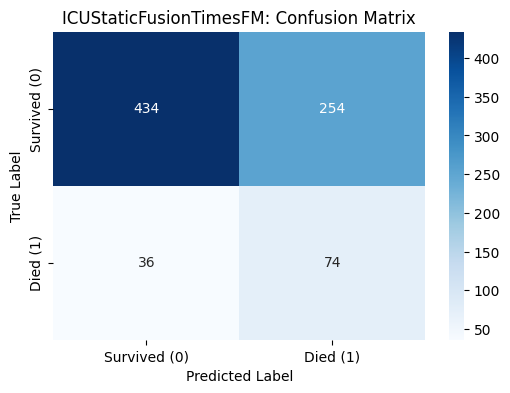

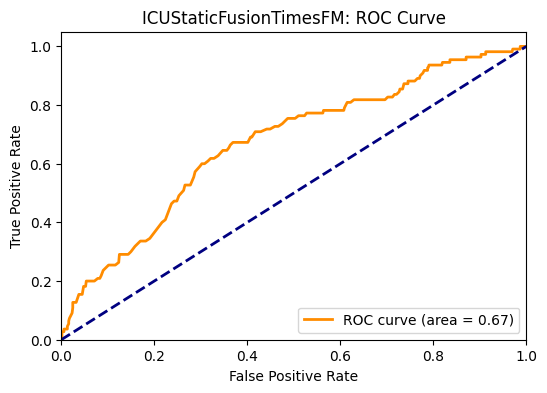

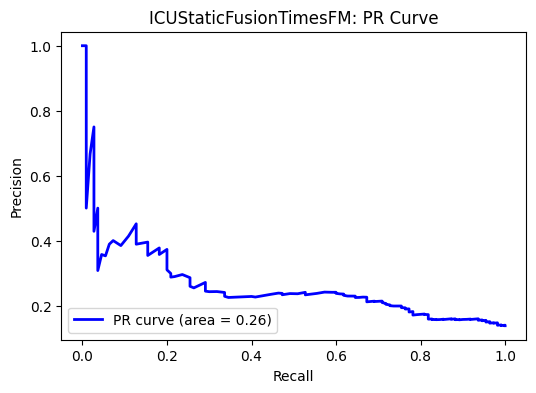

In [ ]:
# Load the best model saved
checkpoints = torch.load(timesFM_bm_path)

# Read the best params
bm_static_projection_size = checkpoints['params']['static_projection_size']
bm_classifier_hidden_size = checkpoints['params']['classifier_hidden_size']
bm_dropout_rate = checkpoints['params']['dropout_rate']
bm_learning_rate = checkpoints['params']['learning_rate']
bm_weight_decay = checkpoints['params']['weight_decay']
bm_batch_size = checkpoints['params']['batch_size']

# Initialize the model with the best params
bm_model = ICUStaticFusionTimesFM(
        static_feature_dim=test_static_feature_dim,
        num_dynamic_features=test_num_dynamic_features,
        static_projection_size=bm_static_projection_size,
        classifier_hidden_size=bm_classifier_hidden_size,
        dropout_rate=bm_dropout_rate
    )
bm_model.to(device)
bm_model.to(torch.bfloat16)

# Initialize the trainer for test dataset to evaluate using the best params
bm_eval_trainer = ICUStaticFusionTimesFM_Trainer(
    model=bm_model,
    train_dataset=None, # No training needed
    val_dataset=None,   # No validation needed
    test_dataset=test_dataset,
    batch_size=bm_batch_size,
    sampler=None, # No sampler needed
    learning_rate=bm_learning_rate,
    weight_decay=bm_weight_decay,
    device=device
)

# Load the saved model state dictionary
bm_eval_trainer.load_model(timesFM_bm_path)

# Evaluate the loaded model on the test set
bm_eval_trainer.evaluate_test()

### 9.3 Model Interpretation Using SHAP

This section utilizes SHAP (SHapley Additive exPlanations) to interpret the predictions of the fine-tuned `ICUStaticFusionTimesFM` model. SHAP values help to understand the contribution of each feature to the model's output for individual predictions and provide a global view of feature importance.

**Interpretations:**

The features like `AgeBMI_token_encoded`, `ICUType`, and `GCS_bin_enc` have the highest impact on mortality predictions. Most features show clinically intuitive behavior—e.g., severe GCS values (high `GCS_bin_enc`) push predictions toward death, while mild values push toward survival. However, `AgeBMI_token_encoded` displays a counterintuitive pattern, where higher age and BMI categories (red dots) are associated with lower predicted mortality, suggesting potential encoding bias or data imbalance. Overall, the plot enhances model transparency by aligning key feature impacts with clinical expectations, while also highlighting areas for further investigation.

In [ ]:
%%time

# Define a new class inheriting from the original model but using float32
# This is often necessary for SHAP compatibility with certain frameworks or devices.
class ICUStaticFusionTimesFM_Float32(ICUStaticFusionTimesFM):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Load TimesFM model with float32 dtype for SHAP
        self.timesfm = TimesFmModelForPrediction.from_pretrained(
            kwargs.get("timesfm_model", "google/timesfm-2.0-500m-pytorch"),
            torch_dtype=torch.float32, # Use float32 for SHAP compatibility
            attn_implementation="sdpa"
        )

# Initialize the model with the best hyperparameters, using the float32 version
bm_model_shap = ICUStaticFusionTimesFM_Float32(
    static_feature_dim=test_static_feature_dim,
    num_dynamic_features=test_num_dynamic_features,
    static_projection_size=bm_static_projection_size,
    classifier_hidden_size=bm_classifier_hidden_size,
    dropout_rate=bm_dropout_rate
)
# Load the state dictionary from the best trained model
bm_model_shap.load_state_dict(checkpoints["model_state_dict"])
# Move the model to the device and set to evaluation mode
bm_model_shap.to(device).eval()

# Prepare background and explain samples for SHAP
num_background_samples = 20 # Number of samples for SHAP background dataset
num_explain_samples = 10 # Number of samples to explain

# Select background samples and move to device
X_static_background = torch.tensor(X_static_test[:num_background_samples], dtype=torch.float32).to(device)
X_dynamic_background = torch.tensor(X_dynamic_test[:num_background_samples], dtype=torch.float32).to(device)
freq_background = torch.zeros(num_background_samples, dtype=torch.long).to(device)

# Select explain samples and move to device
X_static_explain = torch.tensor(X_static_test[num_background_samples:num_background_samples+num_explain_samples], dtype=torch.float32).to(device)
X_dynamic_explain = torch.tensor(X_dynamic_test[num_background_samples:num_background_samples+num_explain_samples], dtype=torch.float32).to(device)
freq_explain = torch.zeros(num_explain_samples, dtype=torch.long).to(device)

# Define the prediction function for SHAP
# This function takes a flattened input and returns the model's output for the positive class.
def predict_fn(flat_input):
    # Split flat input into dynamic and static parts based on original feature dimensions
    dynamic_part = torch.tensor(flat_input[:, :X_dynamic_explain.shape[2]], dtype=torch.float32).unsqueeze(1).repeat(1, X_dynamic_explain.shape[1], 1)
    static_part = torch.tensor(flat_input[:, X_dynamic_explain.shape[2]:], dtype=torch.float32)
    # Create a frequency tensor with zeros for the batch size
    freq_part = torch.zeros(flat_input.shape[0], dtype=torch.long)

    # Move tensors to the device
    dynamic_part = dynamic_part.to(device)
    static_part = static_part.to(device)
    freq_part = freq_part.to(device)

    # Get model logits without gradient calculation
    with torch.no_grad():
        logits = bm_model(dynamic_part, static_part, freq_part)
    # Return the probability of the positive class (class 1)
    return logits[:, 1].cpu().numpy()

# Flatten the dynamic and static inputs for SHAP
# For dynamic data, using the mean across the time dimension as a representative feature
X_explain_flat = torch.cat([X_dynamic_explain.mean(dim=1), X_static_explain], dim=1).cpu().numpy()
X_background_flat = torch.cat([X_dynamic_background.mean(dim=1), X_static_background], dim=1).cpu().numpy()

# Initialize the SHAP KernelExplainer
explainer = shap.KernelExplainer(predict_fn, X_background_flat)
# Calculate SHAP values for the explain samples
shap_values = explainer.shap_values(X_explain_flat)

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 53min 32s, sys: 3min 18s, total: 56min 51s
Wall time: 56min 40s
CPU times: user 53min 32s, sys: 3min 18s, total: 56min 51s
Wall time: 56min 40s


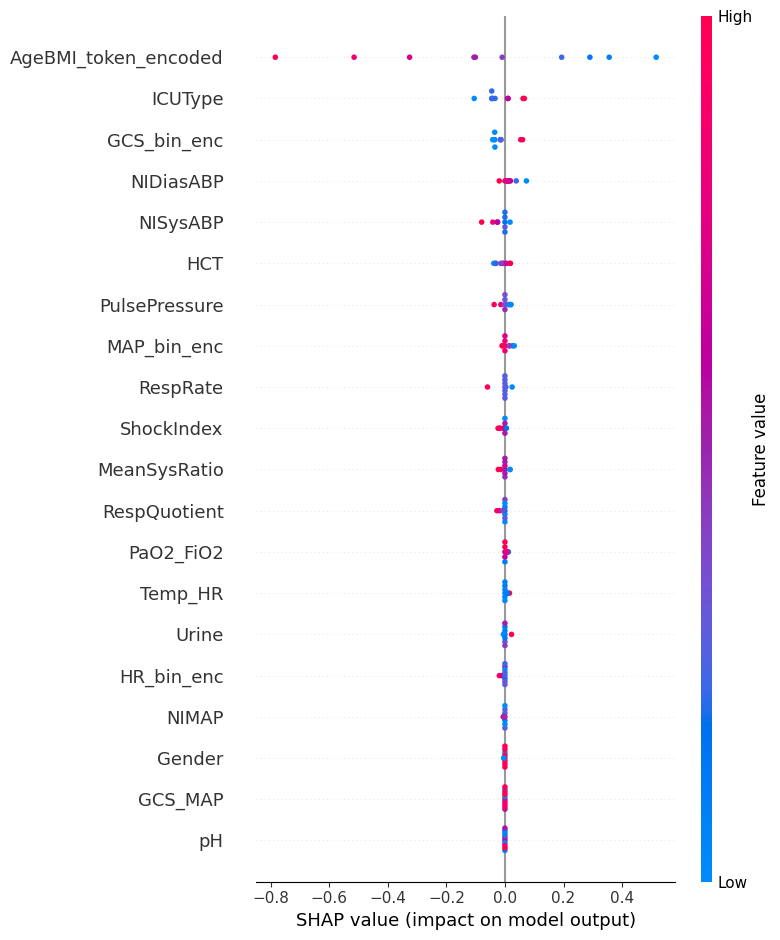

In [ ]:
# Get feature names for plotting
static_feature_names = transformer_static_data_df.drop(columns=["RecordID", "In-hospital_death"]).columns.tolist()
dynamic_feature_names = transformer_dynamic_data_df.drop(columns=["RecordID", "TimeBin"]).columns.tolist()
# Combine dynamic and static feature names
feature_names = dynamic_feature_names + static_feature_names
# Generate the SHAP summary plot
shap.summary_plot(shap_values, X_explain_flat, feature_names=feature_names)

## 10. Compare Model Evaluations

This section provides a comparative analysis of the performance of the `ICUStaticFusionTimesFM` model across different stages: using the pretrained TimesFM backbone without further training, after training on the ICU mortality dataset, and after hyperparameter tuning with Optuna. A table and bar plot are generated to visualize key evaluation metrics for each model version on the test set, allowing for a clear assessment of the impact of training and optimization on the model's predictive capabilities for in-hospital mortality.

**Interpretation:**
*   **Impact of Training:** Comparing the "Pretrained Model" and the "Trained Model":
    *   AUROC increases significantly (0.60 to 0.65), indicating better discrimination.
    *   Accuracy improves (0.65 to 0.73), suggesting more overall correct predictions.
    *   Precision for the "Died" class increases (0.19 to 0.25), meaning fewer false positives for the minority class.
    *   Recall for the "Survived" class improves (0.67 to 0.77), while Recall for "Died" remains similar.
    *   PR_AUC increases (0.17 to 0.23), showing a better precision-recall trade-off for the minority class.
    This demonstrates that training the model on the specific dataset is crucial for adapting the pretrained TimesFM to the downstream task.
*   **Impact of Hyperparameter Tuning:** Comparing the "Trained Model" and the "Tuned Model":
    *   AUROC slightly increases further (0.65 to 0.67), indicating a modest gain in discrimination.
    *   Accuracy decreases (0.73 to 0.64). This highlights the effect of tuning towards metrics that prioritize the minority class over overall accuracy.
    *   Precision for "Died" slightly decreases (0.25 to 0.23).
    *   Recall for "Died" significantly increases (0.48 to 0.67), meaning the tuned model is much better at identifying actual death cases.
    *   PR_AUC increases (0.23 to 0.26), showing an improved precision-recall trade-off that favors higher recall for the minority class.
    Hyperparameter tuning, in this case, prioritized improving the detection rate of the minority class ("Died") even at the expense of a slight increase in false positives and a decrease in overall accuracy and recall for the majority class.

Both training and hyperparameter tuning contribute positively to the model's performance for ICU mortality prediction. While training significantly improves the model from its pretrained state, hyperparameter tuning further refines its ability, particularly in improving the detection of the minority class ("Died"), demonstrating the value of optimizing model parameters for the specific task and data characteristics. The tuned model achieves the best balance of performance metrics relevant to this imbalanced classification problem.

In [ ]:
# Create a dictionary to hold the metrics for comparison
comparison_metrics = {
    'Pretrained Model': eval_trainer_pretrained.test_metrics,
    'Trained Model': trainer.test_metrics,
    'Tuned Model': bm_eval_trainer.test_metrics
}

# Convert the dictionary to a pandas DataFrame for better visualization
comparison_df = pd.DataFrame(comparison_metrics)

# Display the comparison table
print("TimesFM Model Performance Comparison on Test Set:")
display(comparison_df.T)

TimesFM Model Performance Comparison on Test Set:


,AUROC,Accuracy,Precision (survived),Precision (died),Recall (survived),Recall (died),F1-score (survived),F1-score (died),PR_AUC
Pretrained Model,0.601506,0.650376,0.892514,0.194946,0.675872,0.490909,0.769231,0.27907,0.174002
Trained Model,0.651757,0.731830,0.903061,0.252381,0.771802,0.481818,0.832288,0.33125,0.228717
Tuned Model,0.670468,0.636591,0.923404,0.225610,0.630814,0.672727,0.749568,0.33790,0.258856


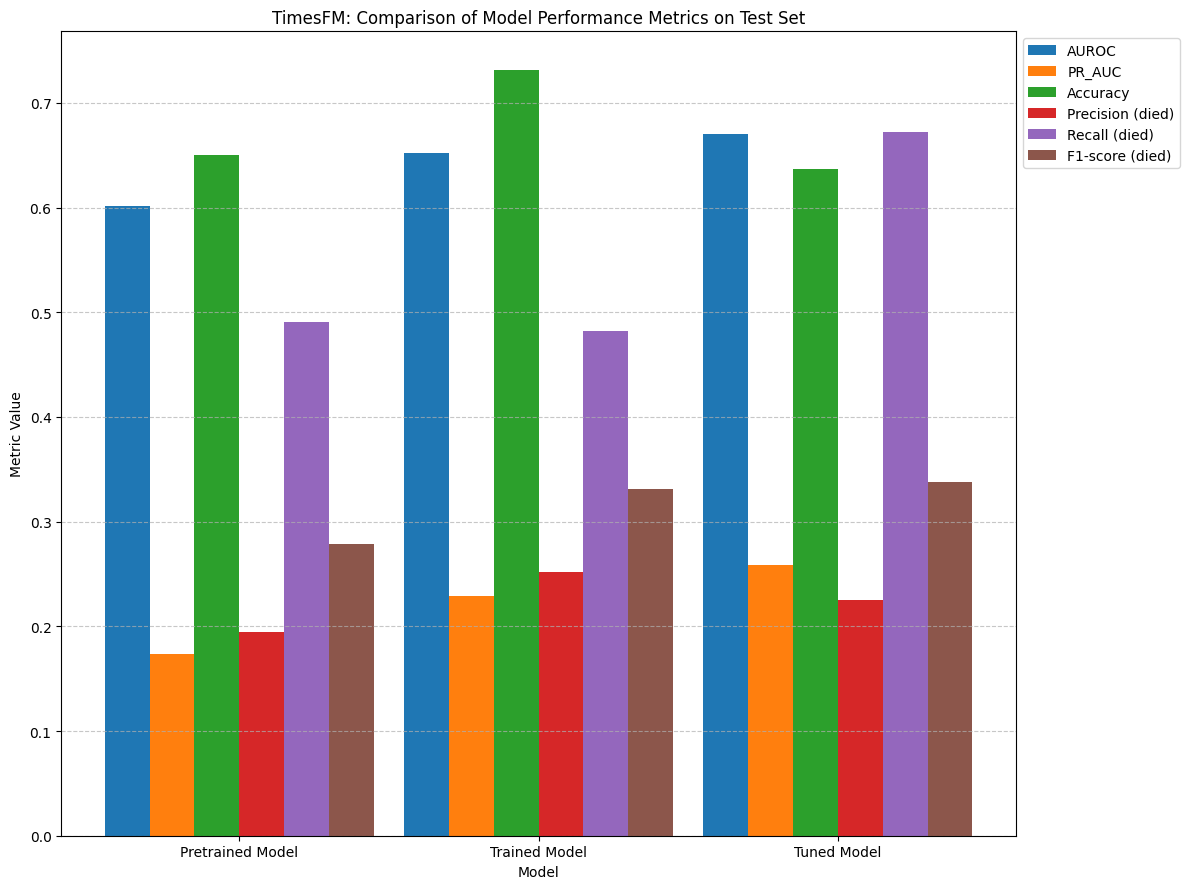

In [ ]:
# Select the metrics to plot
metrics_to_plot = ['AUROC', 'PR_AUC', 'Accuracy', 'Precision (died)', 'Recall (died)', 'F1-score (died)']

# Filter the DataFrame to include only the metrics to plot
plot_df = comparison_df.loc[metrics_to_plot]

# Transpose the DataFrame to have models as rows and metrics as columns for easier plotting
plot_df_transposed = plot_df.T

# Plotting
fig, ax = plt.subplots(figsize=(12, 9))

# Define the width of the bars
bar_width = 0.15

# Define the positions of the bars on the x-axis
index = np.arange(len(plot_df_transposed))

# Create bars for each metric with adjusted positions
for i, metric in enumerate(metrics_to_plot):
    ax.bar(index + i * bar_width - (len(metrics_to_plot) - 1) * bar_width / 2, plot_df_transposed[metric], bar_width, label=metric)


# Set labels, title, and ticks
ax.set_xlabel('Model')
ax.set_ylabel('Metric Value')
ax.set_title('TimesFM: Comparison of Model Performance Metrics on Test Set')
ax.set_xticks(index)
ax.set_xticklabels(plot_df_transposed.index)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Add grid lines for better readability
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Adjust layout to prevent legend from overlapping
plt.tight_layout()

# Display the plot
plt.show()

## References:

Das, A., Kong, W., Sen, R., Zhou, Y., & Research, G. (2024). *A DECODER-ONLY FOUNDATION MODEL FOR TIME-SERIES FORECASTING A PREPRINT*. https://arxiv.org/pdf/2310.10688

PyTorch Contributors. (2022, July 20). *Building Models with PyTorch*. Pytorch.org. https://docs.pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html

*Authentication*. (2025). Huggingface.co. https://huggingface.co/docs/huggingface_hub/en/package_reference/authentication

*User access tokens*. (2025). Huggingface.co. https://huggingface.co/docs/hub/security-tokens